<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/ml/clustering_with_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kneed --q
!pip install yfinance==0.2.43 --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 2.4 MB/s eta 0:00:00


In [2]:
fctr = {0:'Positive distances from MAs, positive price distances Uptrend Investors, swing traders seeking upward momentum',
        1:'Negative distances from MAs, negative price distances Downtrend Short-sellers, traders profiting from downward movements',
        2:'Mixed distances from MAs, longer-term MAs positive Bullish Reversal Investors, traders anticipating a bullish reversal after consolidation',
        3:'Significantly negative distances from MAs and prices Bottoming Out Value investors, contrarian traders seeking buying opportunities',
        4:'Positive distances from shorter-term MAs, longer-term MAs negative Bearish Reversal Traders anticipating a bearish reversal after upward movement',
        5:'Positive distances from all MAs and price distances Strong Uptrend Momentum investors, traders riding the upward trend',
        6:'Positive distances from MAs and prices, smaller magnitudes Stable Uptrend Investors seeking steady growth, less volatility',
        7:'Positive distances from MAs and prices, larger distance from 100-day MA Potential Breakout Breakout traders, investors seeking rapid price appreciation',
        8:'Positive distances from most MAs and prices, negative distance from 100-day MA Volatile Uptrend, Potential Reversal Experienced traders comfortable with high volatility, reversals',
        9:'Mixed distances from MAs, smaller price distances Range-Bound Market Range-bound traders, investors seeking opportunities within a range'}

In [3]:
import yfinance as yf

df = yf.download('^nsei','2010-01-01').reset_index()

# Distance from the moving averages
for m in [10, 20, 30, 50, 100]:
    df[f'feat_dist_from_ma_{m}'] = df['Close']/df['Close'].rolling(m).mean()-1

# Distance from n day max/min
for m in [3, 5, 10, 15, 20, 30, 50, 100]:
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['High'].rolling(m).max()-1
    df[f'feat_dist_from_min_{m}'] = df['Close']/df['Low'].rolling(m).min()-1

# Price distance
for m in [1, 2, 3, 4, 5, 10, 15, 20, 30, 50, 100]:
    df[f'feat_price_dist_{m}'] = df['Close']/df['Close'].shift(m)-1




[*********************100%***********************]  1 of 1 completed


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,feat_dist_from_ma_10,feat_dist_from_ma_20,feat_dist_from_ma_30,...,feat_price_dist_2,feat_price_dist_3,feat_price_dist_4,feat_price_dist_5,feat_price_dist_10,feat_price_dist_15,feat_price_dist_20,feat_price_dist_30,feat_price_dist_50,feat_price_dist_100
3649,2024-11-14,23542.150391,23675.900391,23484.150391,23532.699219,23532.699219,257700,-0.021351,-0.029452,-0.038973,...,-0.014686,-0.025210,-0.025488,-0.027548,-0.027789,-0.035521,-0.049178,-0.068016,-0.066115,-0.000219
3650,2024-11-18,23605.300781,23606.800781,23350.400391,23453.800781,23453.800781,263300,-0.021170,-0.029905,-0.040156,...,-0.004467,-0.017989,-0.028478,-0.028756,-0.034996,-0.030065,-0.056339,-0.062396,-0.067262,-0.011277
3651,2024-11-19,23529.550781,23780.650391,23464.800781,23518.500000,23518.500000,297500,-0.016513,-0.024682,-0.035828,...,-0.000603,-0.001721,-0.015280,-0.025798,-0.019873,-0.033717,-0.050950,-0.051511,-0.053663,-0.014676
3652,2024-11-21,23488.449219,23507.300781,23263.150391,23349.900391,23349.900391,420300,-0.020025,-0.029415,-0.040559,...,-0.004430,-0.007768,-0.008878,-0.022340,-0.035658,-0.045652,-0.045856,-0.066495,-0.063622,-0.028888
3653,2024-11-22,23411.800781,23956.099609,23359.000000,23907.250000,23907.250000,367600,0.005802,-0.005156,-0.016210,...,0.016530,0.019334,0.015916,0.014780,-0.023558,-0.017814,-0.021618,-0.043019,-0.045280,-0.004304


In [5]:
df = df.dropna()
df_train = df[df['Date'] < '2022-01-01'].reset_index(drop=True)
df_test = df[df['Date'] >= '2022-01-01'].reset_index(drop=True)

feat_cols = [col for col in df.columns if 'feat' in col]

## Begin Clustering Efforts

Optimal k: 9


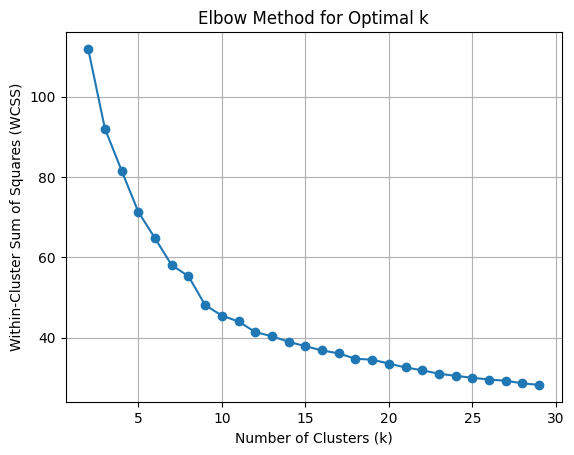

In [6]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kneed import KneeLocator

x_train = df_train[feat_cols]

wcss = []
k_range = range(2, 30)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)

elbow_locator = KneeLocator(k_range, wcss, curve='convex', direction='decreasing')
optimal_k = elbow_locator.elbow

print(f'Optimal k: {optimal_k}')

plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
optimal_kmeans.fit(x_train)

df_train['cluster'] = optimal_kmeans.predict(x_train)

In [7]:
import plotly.express as px

df_plot = df_train[df_train['Date'] > '2012-01-01']

fig = px.scatter(
    df_plot,
    x='Date',
    y='Close',
    color='cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Training',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [8]:
# Analyze and interpret clusters
for i in range(10):
    cluster_data = df_train[df_train['cluster'] == i]
    print(f"Cluster {i}:\n", cluster_data[feat_cols].median())


Cluster 0:
 feat_dist_from_ma_10      0.004516
feat_dist_from_ma_20      0.008821
feat_dist_from_ma_30      0.015139
feat_dist_from_ma_50      0.025418
feat_dist_from_ma_100     0.053303
feat_dist_from_max_3     -0.005558
feat_dist_from_min_3      0.008332
feat_dist_from_max_5     -0.006653
feat_dist_from_min_5      0.012711
feat_dist_from_max_10    -0.008729
feat_dist_from_min_10     0.020537
feat_dist_from_max_15    -0.009964
feat_dist_from_min_15     0.027368
feat_dist_from_max_20    -0.010920
feat_dist_from_min_20     0.034221
feat_dist_from_max_30    -0.011469
feat_dist_from_min_30     0.047889
feat_dist_from_max_50    -0.011976
feat_dist_from_min_50     0.078178
feat_dist_from_max_100   -0.012311
feat_dist_from_min_100    0.149479
feat_price_dist_1         0.000817
feat_price_dist_2         0.001932
feat_price_dist_3         0.003363
feat_price_dist_4         0.004219
feat_price_dist_5         0.004200
feat_price_dist_10        0.009018
feat_price_dist_15        0.012451
feat_pri

In [9]:
import numpy as np

good_clusters=[0,5,6,7,8]

df_plot['good_cluster'] = np.where(df_plot['cluster'].isin(good_clusters), 5, df_plot['cluster'])

fig = px.scatter(
    df_plot,
    x='Date',
    y='Close',
    color='good_cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Training',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

<ipython-input-9-ca0264b47635>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
df_test['cluster'] = optimal_kmeans.predict(df_test[feat_cols])

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing-- LOOK FOR BOTTOMS FORMING[ ***SEE * THIS * FOR * TRADING***]'
)
# [0,4,9] : transition points, [5,6,7]: uptrend , [1,2,3]: downtrend',
# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

``EXECELLENT ANALYSIS``
Cluster	Characteristics	Potential Trend	Suitable For


**0**	Positive distances from MAs, positive price distances	*Uptrend*	Investors, swing traders seeking upward momentum


**1**	Negative distances from MAs, negative price distances	*Downtrend*	Short-sellers, traders profiting from downward movements


**2**	Mixed distances from MAs, longer-term MAs positive	*Bullish Reversal*	Investors, traders anticipating a bullish reversal after consolidation


**3**	Significantly negative distances from MAs and *prices	Bottoming Out*	Value investors, contrarian traders seeking buying opportunities


**4**	Positive distances from shorter-term MAs, longer-term MAs negative	*Bearish Reversal*	Traders anticipating a bearish reversal after upward movement


**5**	Positive distances from all MAs and price distances	*Strong Uptrend*	Momentum investors, traders riding the upward trend


**6**	Positive distances from MAs and prices, smaller magnitudes	*Stable Uptrend*	Investors seeking steady growth, less volatility


**7**	Positive distances from MAs and prices, larger distance from 100-day MA	*Potential Breakout*	Breakout traders, investors seeking rapid price appreciation


**8**	Positive distances from most MAs and prices, negative distance from 100-day MA	*Volatile Uptrend*, Potential Reversal	Experienced traders comfortable with high volatility, reversals


**9**	Mixed distances from MAs, smaller price distances	*Range-Bound Market*	Range-bound traders, investors seeking opportunities within a range

In [11]:
key=df_test['cluster'].iloc[-1]

Cluster	Risk Profile	Description


**Cluster 0**	Low Risk	Stable growth potential with low volatility.


**Cluster 1**	High Risk	Downward trending with potential for significant losses.


**Cluster 2**	Moderate Risk	Potential recovery or mean reversion with moderate volatility.


**Cluster 3**	Very High Risk	Strong bearish trend with potential for significant losses.


**Cluster 4**	Moderate to High Risk	Volatility and potential for fluctuations.


**Cluster 5**	Low Risk	Steady growth potential with slightly higher volatility than Cluster 0.


**Cluster 6**	Low Risk	Moderate growth potential with potentially less volatility than Cluster 5.


**Cluster 7**	Moderate Risk	Potential recovery or mean reversion with moderate volatility.


**Cluster 8**	Moderate Risk	Potential volatility and short-term gains followed by uncertainty.


**Cluster 9**	High Risk	Declining trend with potential for losses, but less severe than Cluster 1 and 3

# [0,4,9] : transition points, [5,6,7]: uptrend , [1,2,3]: downtrend',

In [12]:
print(key,":" ,fctr[key])

8 : Positive distances from most MAs and prices, negative distance from 100-day MA Volatile Uptrend, Potential Reversal Experienced traders comfortable with high volatility, reversals


In [13]:
import numpy as np
good_clusters=[0,5,6,7,8]
df_test['good_cluster'] = np.where(df_test['cluster'].isin(good_clusters), 1,0)

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='good_cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing Set',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

## Quick Backtest

In [14]:
from plotly import graph_objects as go

df_test['pct_change'] = df_test['Close'].pct_change()
df_test['signal'] = df_test['good_cluster'].shift(1)

df_test['equity_cluster'] = np.cumprod(1+df_test['signal']*df_test['pct_change'])
df_test['equity_buy_and_hold'] = np.cumprod(1+df_test['pct_change'])

fig = go.Figure()

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_buy_and_hold'], name='Buy and Hold')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_cluster'], name='Clustering')
)

fig.update_layout(
    title_text='Quick Clustering Backtest',
    legend={'x': 0, 'y':-0.05, 'orientation': 'h'},
    xaxis={'title': 'Date'},
    yaxis={'title': 'Multiple from Initial Investment'}
)

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Random Forest Layer

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

x_train = df_train[feat_cols]
y_train = np.where(df_train['cluster'].isin(good_clusters), 1, 0)

x_test = df_test[feat_cols]
y_test = np.where(df_test['cluster'].isin(good_clusters), 1, 0)

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
)

clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Calculate accuracy and precision for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

# Calculate accuracy and precision for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precision: {train_precision}')
print('')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')

Training Accuracy: 0.955649419218585
Training Precision: 0.9761904761904762

Test Accuracy: 0.9144460028050491
Test Precision: 0.9547413793103449


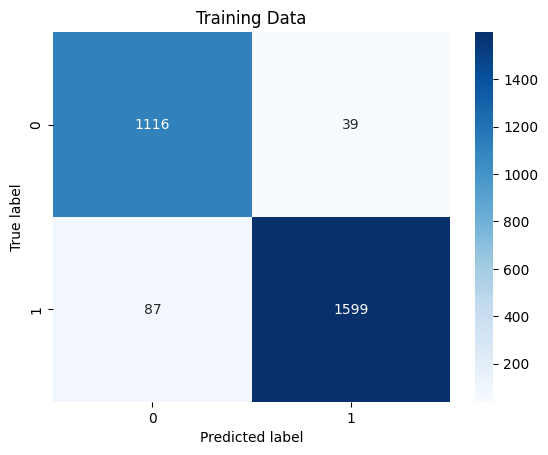

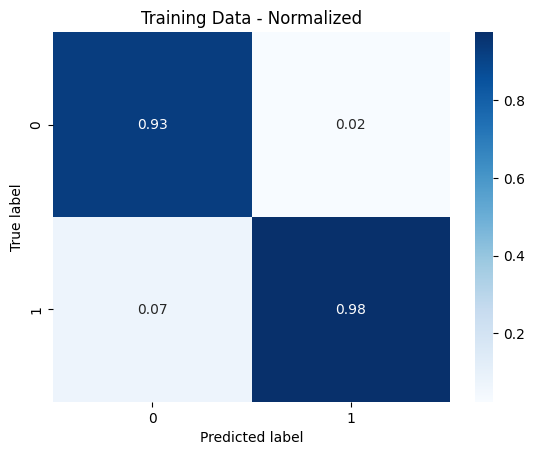

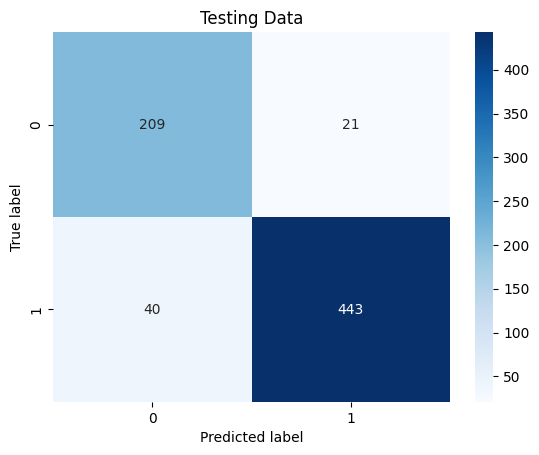

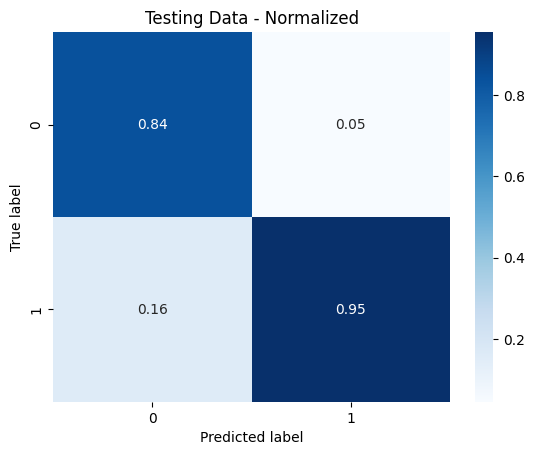

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, normalize):

    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize='pred')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    else:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return

plot_confusion_matrix(y_train, y_train_pred, title='Training Data', normalize=False)
plot_confusion_matrix(y_train, y_train_pred, title='Training Data - Normalized', normalize=True)

plot_confusion_matrix(y_test, y_test_pred, title='Testing Data', normalize=False)
plot_confusion_matrix(y_test, y_test_pred, title='Testing Data - Normalized', normalize=True)

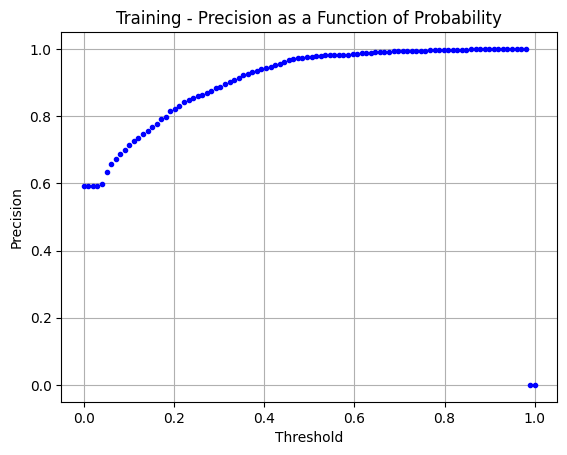

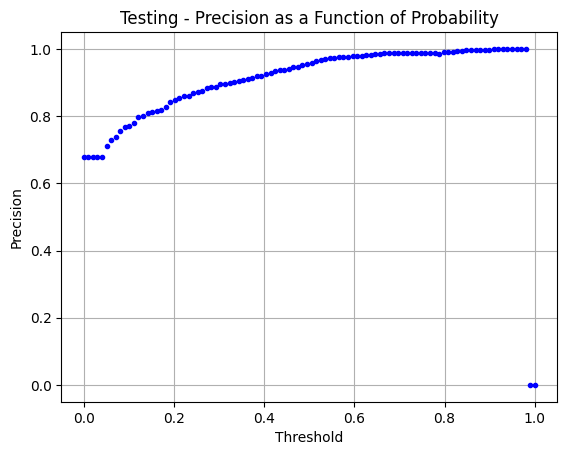

In [17]:
import numpy as np

def get_precision_curve(clf, x, y, title):

    y_scores = clf.predict_proba(x)[:, 1]

    thresholds = np.linspace(0, 1, 100)
    precision = []

    for t in thresholds:
        y_pred_threshold = (y_scores >= t).astype(int)
        precision.append(precision_score(y, y_pred_threshold, zero_division=0))

    plt.plot(thresholds, precision, 'b.')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title(title)
    plt.grid(True)
    plt.show()

    return

get_precision_curve(clf, x_train, y_train, 'Training - Precision as a Function of Probability')
get_precision_curve(clf, x_test, y_test, 'Testing - Precision as a Function of Probability')

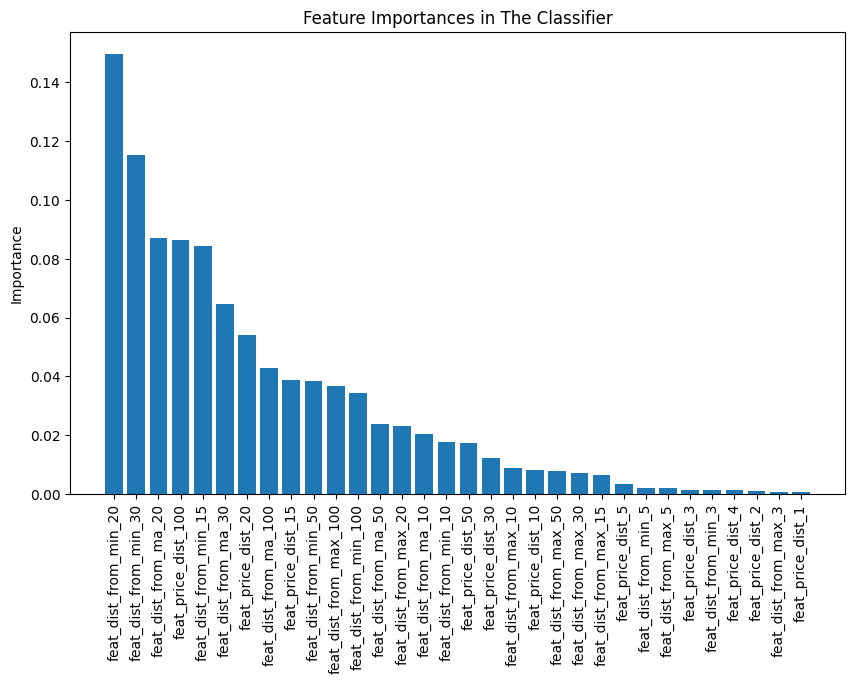

In [18]:
feature_importances = clf.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in The Classifier")
plt.bar(range(x_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.show()

In [19]:
import numpy as np

df_test['rf_pred'] = (clf.predict_proba(x_test)[:, 1] > 0.8).astype(int)

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='rf_pred',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing Set',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [20]:
df_test['rf_signal'] = df_test['rf_pred'].shift(1)
df_test['equity_rf'] = np.cumprod(1+df_test['rf_signal']*df_test['pct_change'])

fig = go.Figure()

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_buy_and_hold'], name='Buy and Hold')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_cluster'], name='Clustering')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_rf'], name='Random Forest')
)

fig.update_layout(
    title_text='Clustering & RF Backtest',
    legend={'x': 0, 'y':-0.05, 'orientation': 'h'},
    xaxis={'title': 'Date'},
    yaxis={'title': 'Multiple from Initial Investment'}
)

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [21]:
def get_max_drawdown(col):
    drawdown = col/col.cummax()-1
    return 100*drawdown.min()

def calculate_cagr(col, n_years):
    cagr = (col.values[-1]/col.values[0])**(1/n_years)-1
    return 100*cagr

print('Maximum Drawdown Buy and Hold:', get_max_drawdown(df_test['equity_buy_and_hold']))
print('Maximum Drawdown Clustering:', get_max_drawdown(df_test['equity_cluster']))
print('Maximum Drawdown Random Forest:', get_max_drawdown(df_test['equity_rf']))

print('')

n_years = (df_test['Date'].max()-df_test['Date'].min()).days/365.25

print('CAGR Buy and Hold:', calculate_cagr(df_test['equity_buy_and_hold'].dropna(), n_years))
print('CAGR Clustering:', calculate_cagr(df_test['equity_cluster'].dropna(), n_years))
print('CAGR Random Forest:', calculate_cagr(df_test['equity_rf'].dropna(), n_years))

Maximum Drawdown Buy and Hold: -16.46593406030692
Maximum Drawdown Clustering: -10.130945685316151
Maximum Drawdown Random Forest: -10.457366960359805

CAGR Buy and Hold: 10.751684807060213
CAGR Clustering: 3.844894590977743
CAGR Random Forest: 5.24244481911762
